# Timepix3 Parser prototype

This notebook demonstrates how to parse a particular Timepix3 raw event stream file, found at https://zenodo.org/record/3635923. The data used were those under `experimental_200kv/edge/edge1_000001.tpx3`.

The decoding logic and file structure were inferred from (and heavily inspired by) the repository https://github.com/M4I-nanoscopy/tpx3HitParser and in particular the file https://github.com/M4I-nanoscopy/tpx3HitParser/blob/master/tpx3format/read.py.

## The file format
The file is encoded as a sequence of little-endian longlong unsigned integers (`np.uint64`) each of which encodes either a header packet or a data packet via bit-packing. Header packets have the following structure:

In [1]:
import ctypes

class HeaderPacket_bitfield(ctypes.LittleEndianStructure):
    _fields_ = [
        ("title", ctypes.c_char * 4),  # LSB
        ('chip_nr', ctypes.c_ubyte),
        ('mode', ctypes.c_ubyte),
        ('size', ctypes.c_ushort),  # MSB
    ]

with four fields:
- `title`: which is the literal `char[4]` array `TPX3`
- `chip_nr`: an integer in `(0, 1, 2, 3)` for the four timepix chips
- `mode`: presumably a chip mode flag, all the data seen so far are `mode == 0`
- `size`: uint16 number of bytes of payload following the header, `size % 8 == 0` is always True. 
  - In the data that I've seen I believe that `min(size) == 8` i.e. we always have at least one packet of payload even for control messages.


I'm using `ctypes.Structure` to decode the bytes in this notebook because it's compact notation that avoids doing a lot of bitshifting, and it also lets me look into the elements of an `np.array` as if they were decoded. As of right now I haven't figured out how to use this decoder in 'fast' or vectorized code, except for the obvious way which would be to write a C function to unpack the bits!

In [2]:
"""Helper functions"""
import numpy as np

class HeaderPacket(ctypes.Union):
    # Decodes .base as bitfield .b
    _fields_ = [
        ('base', ctypes.c_ulonglong),
        ('b', HeaderPacket_bitfield),
    ]
    
def bitfield_repr(obj, bf=None):
    """This is just for prettyprinting of bitfield objects"""
    if bf is None:
        bf = obj
    _repr = f'{obj.__class__.__name__.replace("_bitfield", "")}('
    for field in bf._fields_:
        name = field[0]
        try:
            value = getattr(obj.b, name)
        except AttributeError:
            value = getattr(obj, name)
        _repr = _repr + f'{name}={value}, '
    return _repr[:-2] + ')'

We can decode a header as such:

In [3]:
header = HeaderPacket()
# point the header object at a uint64 to give us the decoded view
header.base = np.uint64(58546808902144084)
print(bitfield_repr(header, bf=HeaderPacket_bitfield))

HeaderPacket(title=b'TPX3', chip_nr=3, mode=0, size=208)


A data packet for hit events is encoded as such (other types of data packets also exist):

In [4]:
c_ulong = ctypes.c_ulong
class EventsPacket_bitfield(ctypes.LittleEndianStructure):
    _pack_ = 1
    _fields_ = [
        # must use c_ulong for decoding here as the bitmask is not byte-aligned (?)
        # the true number of bits for each field in the bitmask is specified by the integers
        ("spidr", c_ulong, 16),  # LSB
        ("fine_toa", c_ulong, 4),
        ("tot", c_ulong, 10),
        ("coarse_toa", c_ulong, 14),
        ("pix", c_ulong, 3),
        ("super_pix", c_ulong, 6),
        ("col", c_ulong, 7),
        ("pkg_type", c_ulong, 4),  # MSB
    ]

    
class EventsPacket(ctypes.Union):
    _fields_ = [
        ('base', ctypes.c_ulonglong),
        ('b', EventsPacket_bitfield),
    ]

And we can get a view into an array of events like this:

In [5]:
arr = np.array((13322656592034140556, 13313702169348149644), dtype=np.uint64)
arr_b = arr.ctypes.data_as(ctypes.POINTER(EventsPacket_bitfield))

In [6]:
print(bitfield_repr(arr_b[0]))
print(bitfield_repr(arr_b[1]))

EventsPacket(spidr=4492, fine_toa=6, tot=11, coarse_toa=5718, pix=1, super_pix=7, col=71, pkg_type=11)
EventsPacket(spidr=4492, fine_toa=8, tot=21, coarse_toa=5718, pix=4, super_pix=7, col=70, pkg_type=11)


The fields in the packet are as such:

- `pkg_type`: identifies the package, this is `0xb == 11` for hit events
  - Other `pkg_types` in the upstream repo are:
     - `0x7`, control packet
     - `0x4`, heartbeat packet
     - `0x6`, TDC timestamp packet "TDC (Time to Digital Converter) packages can come from the external trigger"
  - For which some information exists in their decoder, but I haven't gone much into the details.
- `spidr`: this is the main time source, it is a 16-bit unsigned counter with a rollover time of 26.8435456 seconds (4.1 μs resolution)
- `coarse_toa` (u14-bit), `fine_toa` (u4-bit): these are extra bits of time resolution which are concatenated with `spidr` to give a 34-bit timestamp with the same rollover time (~1.5 ns resolution)
  - I believe `toa` stands for time-of-arrival
  - in the upstream decoder the two toa values are combined as `toa = (coarse_toa << 4) - fine_toa` to make an 18-bit counter
  - In the upstream code there are correction procedures for `toa` values depending on `chip_nr` and perhaps even row/column, I suppose to correct for phase differences due to trace lengths or particular chip characteristics.
 - `tot`: standing for 'time over threshold', a u10-bit counter, unknown units, representing 'intensity' of the hit event
 - `pix`, `super_pix`, `col`: represent the information used to compute the `x`/`y` position of the hit event for that chip reporting events. It seems that a single chip has a resolution of 256x256.
 
It seems to be that each header packet defines a payload linked to one chip, therefore I assume that all the hit events following a header belong to that chip.

## Timing and rollovers

A note on timestamps: in these raw files there seem to be no global timestamps attached to headers or events. There is only the single clock with the 26.8 second rollover (and this itself is possibly variable depending on if the camera is externally clocked, or if the clock has jitter or drift). It is possible that there is some kind of global timestamp in the other `pkg_types`(heartbeat or TDC package, perhaps) but I haven't seen it yet.

What this means is that we need to inspect the whole file at a coarse sampling to estimate the number of 26.8 second periods / rollovers that it contains, and add an offset to subsequent packets each time the counter rolls over.

## Parse some real data

In [7]:
import pathlib
data_path = pathlib.Path('./edge1_000001.tpx3')

In [8]:
memmap = np.memmap(data_path, mode='r', dtype=np.uint64)
print(memmap.shape)

(88797908,)


The majority of this file is hits data, and at ~700 MB we have ~88 million events to parse.

In [9]:
header.base = memmap[0]
print(bitfield_repr(header, bf=HeaderPacket_bitfield))

HeaderPacket(title=b'TPX3', chip_nr=2, mode=0, size=8)


Since this is the beginning of the file we haven't yet found any hit data, in fact this is a control packet as we will see if we try to decode the next item:

In [10]:
events = EventsPacket()
events.base = memmap[1]
print(bitfield_repr(events, bf=EventsPacket_bitfield))

EventsPacket(spidr=47388, fine_toa=12, tot=646, coarse_toa=0, pix=0, super_pix=0, col=16, pkg_type=7)


As we can see the `pkg_type` is 7 which is for a control packet. The rest of the data under this decoding should be considered invalid.

Let's fast-forward to the first data packet with a generator over the headers in the file:

In [11]:
def generate_headers(array: np.ndarray, start_offset: int = 0) -> int:
    # Yields the absolute index in array of header values starting from start_offset
    # Will seek to first header if start_offset initially points at a non-header item
    header_view = array.ctypes.data_as(ctypes.POINTER(HeaderPacket_bitfield))
    
    offset = start_offset
    while offset < array.size - 1:
        if header_view[offset].title == b'TPX3' and header_view[offset].mode == 0:
            yield offset
            # Skip the payload
            offset += (header_view[offset].size // 8) #  the .size field is in bytes
        # Add one to seek onto the next item
        offset += 1

In [12]:
header_view = memmap.ctypes.data_as(ctypes.POINTER(HeaderPacket_bitfield))
events_view = memmap.ctypes.data_as(ctypes.POINTER(EventsPacket_bitfield))

for header_offset in generate_headers(memmap):
    if events_view[header_offset + 1].pkg_type == 0xb:
        break

print(f'Header at idx {header_offset}')
print(bitfield_repr(header_view[header_offset]))
print(bitfield_repr(events_view[header_offset + 1]))

Header at idx 200
HeaderPacket(title=b'TPX3', chip_nr=3, mode=0, size=648)
EventsPacket(spidr=125, fine_toa=15, tot=27, coarse_toa=13205, pix=0, super_pix=3, col=114, pkg_type=11)


which has the correct `pkg_type` of 11.

### Composition of the file

We can inspect the types and sizes of packets present in this file:

In [13]:
header_mapping = {0xb: 'hits', 0x7: 'control', 0x4: 'hearbeat', 0x6: 'tdc timestamp'}
header_counters = {}
payload_sizes = {}
hit_timestamps = []
for header_offset_t in generate_headers(memmap):
    size = header_view[header_offset_t].size
    pkg_type = 'no_payload' if size == 0 else header_mapping[events_view[header_offset_t + 1].pkg_type]
    try:
        header_counters[pkg_type] += 1
    except KeyError:
        header_counters[pkg_type] = 1
    try:
        payload_sizes[pkg_type][size // 8] += 1
    except KeyError:
        payload_sizes[pkg_type] = payload_sizes.get(pkg_type, {})
        payload_sizes[pkg_type][size // 8] = 1
    if pkg_type == 'hits':
        hit_time = events_view[header_offset_t + 1].spidr
        hit_timestamps.append((header_offset_t, hit_time))

Number of header packets: {'control': 100, 'hits': 374585}
Control payload size (uint64): {1}
Min hits payload size (uint64) 1
Max hits payload size (uint64) 1119


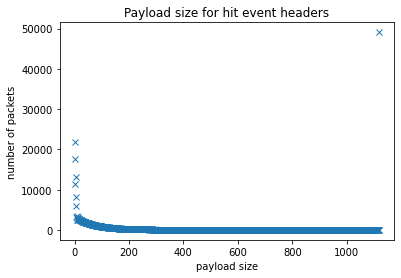

In [14]:
import matplotlib.pyplot as plt
print(f'Number of header packets: {header_counters}')
print(f"Control payload size (uint64): {set(payload_sizes['control'].keys())}")
print(f"Min hits payload size (uint64) {min(payload_sizes['hits'].keys())}")
print(f"Max hits payload size (uint64) {max(payload_sizes['hits'].keys())}")
plt.plot(payload_sizes['hits'].keys(), payload_sizes['hits'].values(), 'x')
plt.xlabel('payload size');
plt.ylabel('number of packets');
plt.title('Payload size for hit event headers');

We can also inspect the timestamps for the first hit in each events payload:

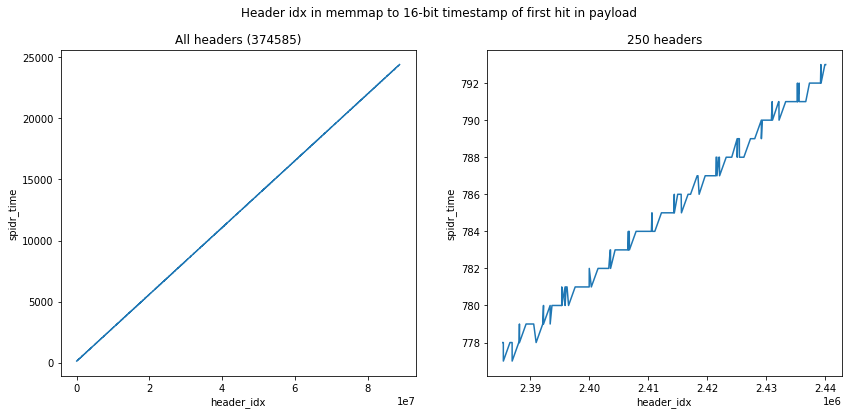

In [15]:
hslice = slice(10000, 10250)
hit_timestamps = np.asarray(hit_timestamps).reshape(-1, 2)
fig, (ax0, ax1) = plt.subplots(1, 2, figsize=(14, 6))
ax0.plot(hit_timestamps[:, 0], hit_timestamps[:, 1])
ax0.set_xlabel('header_idx');
ax0.set_ylabel('spidr_time');
ax0.set_title(f'All headers ({hit_timestamps.shape[0]})');
ax1.plot(hit_timestamps[hslice, 0], hit_timestamps[hslice, 1])
ax1.set_xlabel('header_idx');
ax1.set_ylabel('spidr_time');
ax1.set_title('250 headers');
fig.suptitle('Header idx in memmap to 16-bit timestamp of first hit in payload');

Clearly the payloads themselves can arrive slightly out-of-order. One unit of spidr_time is 4.1 μs.

In [16]:
diff = np.diff(hit_timestamps[:, 1].astype(int))
values, counts = np.unique(diff, return_counts=True)
for v, c in zip(values, counts):
    print(f'{v:>3d} => {c}')

-10 => 4
 -9 => 3
 -8 => 1
 -7 => 2
 -6 => 9
 -5 => 2
 -4 => 6
 -3 => 7
 -2 => 113
 -1 => 36101
  0 => 278047
  1 => 59871
  2 => 389
  3 => 6
  4 => 6
  5 => 2
  6 => 6
  7 => 3
  8 => 1
  9 => 4
 10 => 1


### Parse a block of hit events

Sadly `numba` doesn't support nice `ctypes` bitfields/structs so we have to do a lot of manual bitshifting and bitmasking to decode using `numba` on an array of event integers:

In [17]:
import numba

@numba.njit
def parse_hit_data(hit_data: np.ndarray, chip_nr: int,
                   out_buffer: np.ndarray, cross_offset: int = 2):
    """
    Parse a 1D array of np.uint64 event packets into the (6, hit_data.size) np.uint16 out_buffer
    """
    col = (hit_data & np.uint64(0x0FE0000000000000)) >> np.uint64(52)
    super_pix = (hit_data & np.uint64(0x001F800000000000)) >> np.uint64(45)
    pix = (hit_data & np.uint64(0x0000700000000000)) >> np.uint64(44)
    parse_time_data_inplace(hit_data, out_buffer[3:6])
    # tot
    out_buffer[2] = ((hit_data >> np.uint64(16 + 4)) & np.uint64(0x3ff)).astype(np.uint16)
    convert_position_data(col.astype(np.uint16),
                          super_pix.astype(np.uint16),
                          pix.astype(np.uint16),
                          chip_nr,
                          out_buffer[0],
                          out_buffer[1],
                          cross_offset=cross_offset)


@numba.njit
def parse_time_data_inplace(hit_data: np.ndarray, out_buffer: np.ndarray):
    # spidr
    out_buffer[0] = np.bitwise_and(hit_data, np.uint64(0xffff))
    # coarse_toa
    out_buffer[1] = np.bitwise_and(hit_data >> np.uint64(16 + 14), np.uint64(0x3fff))
    # fine_toa
    out_buffer[2] = np.bitwise_and(hit_data >> np.uint64(16), np.uint64(0xf))


@numba.njit
def convert_position_data(col: np.ndarray,
                          super_pix: np.ndarray,
                          pix: np.ndarray,
                          chip_nr: int,
                          out_x: np.ndarray,
                          out_y: np.ndarray,
                          cross_offset: int = 2):
    # the x/y position values are for one chip so all np.uint8 (256x256 chip)
    # potential overflow issues here ?? probably impossible given the chip design
    out_x[:] = col + (pix >> np.uint16(2))
    out_y[:] = super_pix + (pix & np.uint16(0x3))
    combine_chips(out_x, out_y, chip_nr, cross_offset=cross_offset)

I've also adapted the code here to convert the per-chip x/y to the full sensor x/y. The parameter `cross_offset` pads the position values for chips `0, 1, 3` appropriately to account for the space between chips. In the upstream library the default `cross_offset == 2` giving a true sig_shape of (516, 516).

In [18]:
@numba.njit
def combine_chips(x: np.ndarray, y: np.ndarray, chip_nr: int, cross_offset: int = 2):
    """
    correction is applied inplace on x and y

    Chip are orientated like this (unspecified x/y orientation)
    2 1
    3 0
    """
    # Calculate extra offset required for the cross pixels
    offset = np.uint16(256 + 2 * cross_offset)
    size = np.uint16(255)

    if chip_nr == 0:
        x[:] += offset
        y[:] = size - y + offset
    elif chip_nr == 1:
        x[:] = size - x + offset
    elif chip_nr == 2:
        x[:] = size - x
    elif chip_nr == 3:
        y[:] = size - y + offset

Parse one block:

In [19]:
n_events = header_view[header_offset].size // 8
chip_nr = header_view[header_offset].chip_nr
first_event_idx = header_offset + 1
event_data = memmap[first_event_idx: first_event_idx + n_events]
out_buffer = np.empty((6, n_events), dtype=np.uint16)

print(f'Parsing {n_events} hits')
parse_hit_data(event_data, chip_nr, out_buffer)

Parsing 81 hits


Which gives the following structure (truncated):

In [20]:
import pandas as pd  # pd just for prettyprint
fields = 'x', 'y', 'tot', 'spidr', 'coarse_toa', 'fine_toa'
pd.DataFrame(data=out_buffer.T[:10], columns=fields)

,x,y,tot,spidr,coarse_toa,fine_toa
0,228,503,27,125,13205,15
1,229,504,18,125,13205,15
2,10,479,100,125,13205,15
3,10,480,62,125,13205,15
4,229,503,31,125,13205,15
5,228,504,52,125,13205,15
6,229,502,45,125,13205,15
7,30,483,5,125,13469,3
8,32,481,13,125,13470,15
9,24,491,20,125,13470,4


We can combine the three timestamps with the following function:

In [21]:
@numba.njit
def get_global_time_no_roll(spidr_time, coarse_toa, fine_toa):
    toa = (coarse_toa.astype(np.uint64) << np.uint64(4)) - fine_toa
    global_time = (spidr_time.astype(np.uint64) << np.uint64(18)) + toa
    return global_time

which must return `np.uint64` as we have 34 bits of resolution once combined.

In [22]:
global_timestamps = get_global_time_no_roll(out_buffer[3], out_buffer[4], out_buffer[5])

Plotting this we can see that the events within a payload are indeed also out-of-order.

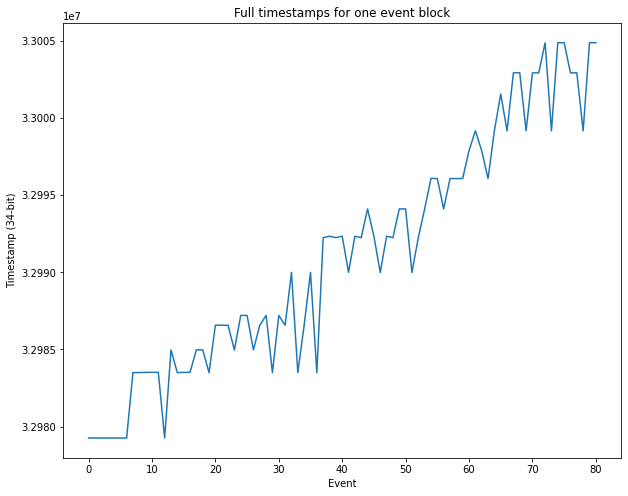

In [23]:
fig, ax = plt.subplots(figsize=(10, 8))
ax.plot(global_timestamps)
ax.set_title('Full timestamps for one event block');
ax.set_xlabel('Event');
ax.set_ylabel('Timestamp (34-bit)');

Note again that the timestamps here are not corrected for rollover, so we might find events with exactly the same timestamp much later in the file. (In this particular file the whole acquisition was around 20 seconds so in fact there are no rollover events).

Depending on the dwell time it might be a reasonable assumption that all of the data in a single packet comes from a single scan point. This would reduce the complexity of sorting or filtering out-of-order / out-of-span data considerably, we could do it essentially on a per-header basis rather than a per-event basis!


## Parsing many events

If we parse many more events we can compile a frame. The parsing can be completely converted to `numba` functions (including finding headers) but here I stick to the Python generator for compactness.

In [24]:
total_events = 100_000

In [25]:
acc = 0
out_buffer_full = np.empty((6, total_events), dtype=np.uint16)

for header_offset in generate_headers(memmap):
    if acc >= total_events: break
    if events_view[header_offset + 1].pkg_type == 0xb:
        n_events = min(header_view[header_offset].size // 8, total_events - acc)
        chip_nr = header_view[header_offset].chip_nr
        first_event_idx = header_offset + 1
        event_data = memmap[first_event_idx: first_event_idx + n_events]
        parse_hit_data(event_data, chip_nr, out_buffer_full[:, acc: acc + n_events])
        acc += n_events

With a fully `numba`-fied parser performance was on the order of 1 million events in 20 ms on a single core.

In [26]:
hits = out_buffer_full
hits.shape

(6, 100000)

We can do a rough check that there was no rollover in this period by inspecting the min/max spidr timers:

In [27]:
ROLLOVER_TIME = 26.8435456  # s

spidr_min, spidr_max = hits[3].min(), hits[3].max()
print(f'min {spidr_min}, max {spidr_max}, real_time ~ {ROLLOVER_TIME * (spidr_max - spidr_min) / 2**16:.3f} s')

min 125, max 153, real_time ~ 0.011 s


So on these data we had 100k events in 0.01 seconds and we were far from a rollover.

## Combining events

To create a sparse frame we need to combine hits on identical pixels so that we can sum the "intensity" or `tot` values. After decoding the hits are both out-of-order and potentially duplicated.

In [28]:
import sparse
from scipy.sparse import coo_array

sig_shape = (516, 516) # +4 for cross/boundary pixels
flat_idcs = np.ravel_multi_index((hits[1], hits[0]), sig_shape)

Both `scipy.sparse` and `pydata.sparse` have functions to sum duplicate values in a sparse array - both are implemented essentially like the following function:

In [29]:
def sort_and_deduplicate(flat_idcs, values):
    order = np.argsort(flat_idcs, kind="mergesort")
    flat_idcs = flat_idcs[order]
    values = values[order]
    unique_mask = flat_idcs[1:] != flat_idcs[:-1]
    unique_mask = np.append(True, unique_mask)
    unique_idcs = flat_idcs[unique_mask]
    groups, = np.nonzero(unique_mask)
    summed_values = np.add.reduceat(values, groups, dtype=np.uint64)
    return unique_idcs, summed_values

In [30]:
%%timeit
sp_unique, sp_values = sort_and_deduplicate(flat_idcs, hits[2])
unique_coords = np.stack(np.unravel_index(sp_unique, sig_shape), axis=0)
sparse_frame = sparse.COO(unique_coords, sp_values, shape=sig_shape, sorted=True, has_duplicates=False)

11 ms ± 475 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


Which is not a cheap operation! In the above the `argsort` is the major component:

In [31]:
%%timeit
np.argsort(flat_idcs, kind="mergesort")

7.12 ms ± 270 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


Plotting the frame:

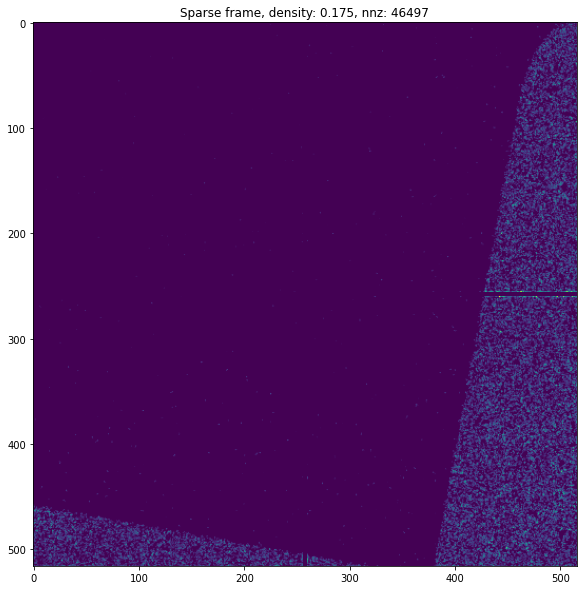

In [32]:
sp_unique, sp_values = sort_and_deduplicate(flat_idcs, hits[2])
unique_coords = np.stack(np.unravel_index(sp_unique, sig_shape), axis=0)
sparse_frame = sparse.COO(unique_coords, sp_values, shape=sig_shape, sorted=True, has_duplicates=False)

fig, ax = plt.subplots(figsize=(10, 10))
ax.imshow(sparse_frame.todense());
ax.set_title(f'Sparse frame, density: {sparse_frame.density:.3f}, nnz: {sparse_frame.nnz}');

Note, in the upstream library there is also a correction step for the `ToT` values on a chip / row / column basis which I haven't implemented here. They also have a minimum `ToT` threshold to consider an event valid, by default they use `5`.

### Compare sparse array construction to densification

For comparison's sake, here is what happens if we combine the hits data without de-duplication by accumulating into a full-sized frame:

In [33]:
@numba.njit
def densify(flat_idcs, values, out_buffer):
    for idx in range(len(flat_idcs)):
        flat_idx = flat_idcs[idx]
        out_buffer[flat_idx] += values[idx]
        
def make_dense(flat, values, shape):
    dense_frame = np.zeros(np.prod(shape), dtype=np.uint64)
    densify(flat, values, dense_frame)
    return dense_frame.reshape(shape)

In [34]:
%%timeit
make_dense(flat_idcs, hits[2], sig_shape)

345 µs ± 67.8 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


This will not scale well as the frame size or array density increases, but in the Timepix3 case this might represent a good solution?

`scipy.sparse` has a compiled C++ implementation of densification of a `coo_array` that skips the Python deduplication step, this is comparable to the numba implementation above:

In [35]:
# Array construction with copy=True because a lot of operations are inplace
sparse_frame_sp = coo_array((hits[2], (hits[1], hits[0])), shape=sig_shape, dtype=np.uint64, copy=True)

In [36]:
%%timeit
densified_sp = sparse_frame_sp.todense()

395 µs ± 35.5 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


Check for equivalency:

In [37]:
c1 = np.allclose(sparse_frame_sp.todense(), make_dense(flat_idcs, hits[2], sig_shape))
c2 = np.allclose(sparse_frame.todense(), sparse_frame_sp.todense())
print(c1, c2)

True True


Finally, check densification as a method of deduplication:

In [38]:
%%timeit
dense = make_dense(flat_idcs, hits[2], sig_shape)
coords = np.argwhere(dense)
values = dense[coords[:, 0], coords[:, 1]]
sparse_frame = sparse.COO(coords.T, values, sorted=True, has_duplicates=False, shape=sig_shape)

2.72 ms ± 254 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


Which is the winner for sparse construction at this frame size and density!

## Interpreting this in LiberTEM

So to make this work in LiberTEM we have a few challenges to overcome:

- Calculating file offsets for a given frame / tile needs us to know the timestamp to offset mapping, which we can only get by decoding a bunch of events scattered through the file
    - In this process the timestamps need to be adjusted for counter rollover
    - The timestamp-to-offset mapping is not monotonic, the max jitter in this file is on the order of 40 μs.
    - Probably shouldn't assume a constant timestamp-to-offset ratio (even approximately), as the hit rate may vary significantly over the field of view.
- To ensure we catch all events for a frame or tile, even out-of-order events, we need to parse some events before and after the main block for that section of the file and discard those which are out-of-range.
- If we want to yield sparse frames we need to be able to combine events efficiently over given blocks of time
    - This could maybe happen as part of the decoding
- Partitions should be allocated for equal amounts of data, with some overlap, to account for OOOness and variable event rate
    - From the point of view of the library they still need a frame allocation so we will need to instantiate them with knowledge of the file contents
- Must be careful around rollover where OOO events may jump each side of `max(np.uint16)`

### Step 1: (Sparsely) sample file structure

As a first step we must identify the approximate relationship between `offset` in the file and the timestamp of the events, this can be done by reading small chunks of the file and decoding the first hit timestamp in the chunk. The following functions provide a way to read an arbitrary chunk of the file and return the first hit timestamp after a header:

In [39]:
@numba.njit
def is_header(value: np.uint64) -> bool:
    """
    title_ints = tuple(np.uint64(ord(x)) << np.uint64(i * 8) for i, x in enumerate('TPX3'))
    title_ints[3] | title_ints[2] | title_ints[1] | title_ints[0] == np.uint64(0x33585054)
    """
    return (value & np.uint64(0xffffffff)) == np.uint64(0x33585054)


@numba.njit
def is_hit(value: np.uint64) -> bool:
    """Bitmask with 0xb on bits 64:60"""
    return (value & np.uint64(0xf000000000000000)) == np.uint64(0xb000000000000000)


@numba.njit
def find_hits_header(data: np.ndarray):
    """Return index in data of first hits header, else -1 if no hits header found"""
    for idx in range(len(data)):
        value = data[idx]
        if is_header(value):
            next_value = data[idx + 1]
            if is_hit(next_value):
                return idx
    return -1

READ_BLOCKSIZE = 8192

def find_timestamp_near(filepath: str, offset: int, max_offset: int) -> tuple[int, np.uint64]:
    """
    Return (file_offset, first_hit_timestamp) after a header in the file, search starting from offset
    Sequentially read READ_BLOCKSIZE bytes until a header + timestamp is found,
    else return (None, None) if we reach max_offset or end of file
    """
    offset = int(offset)
    assert offset % 8 == 0
    read_count = READ_BLOCKSIZE // 8
    out_buffer = np.empty((read_count,), dtype=np.uint64) 
    header_idx = -1
    while header_idx < 0:
        try:
            out_buffer[:] = np.fromfile(filepath, count=read_count, dtype=np.uint64, offset=offset)
        except ValueError:
            # Unable to read full chunk of data, must be near end of file, i.e. break
            return None, None
        offset += (read_count * 8)
        header_idx = find_hits_header(out_buffer)
        if offset >= max_offset:
            return None, None
    time_buffer = np.zeros((3, 1), dtype=np.uint16)
    try:
        parse_time_data_inplace(out_buffer[header_idx + 1], time_buffer)
    except IndexError:
        return None, None
    global_time = get_global_time_no_roll(time_buffer[0], time_buffer[1], time_buffer[2])
    return offset - ((out_buffer.size - header_idx) * 8), global_time.item()

The actual traversal of the file is looped over a set of offsets, this could be parallellised with `executor.map`:

In [40]:
import os

def read_file_structure(filepath, n_samples=512, start_offset=0, max_offset=None) -> list[tuple[int, np.uint64]]:
    """
    Sample the file at filepath n_samples times, and return
    a list of (file_offset, timestamp) pairs
    where a hits header could be found in the sample
    
    length of return list is <= n_samples
    """
    if max_offset is None:
        max_offset = os.stat(filepath).st_size
    offsets = np.linspace(start_offset, max_offset, num=n_samples, endpoint=True).astype(int)
    offsets -= (offsets % 8)
    structure = []
    for offset, next_offset in zip(offsets[:-1], offsets[1:]):
        header_offset, global_time = find_timestamp_near(filepath, offset, next_offset)
        if header_offset is not None:
            structure.append((header_offset, global_time))
    return structure

In [41]:
%%time
structure = read_file_structure(data_path)

CPU times: user 351 ms, sys: 3.81 ms, total: 354 ms
Wall time: 357 ms


Plotting the file structure:

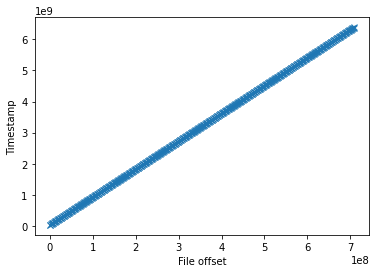

In [42]:
structure = np.asarray(read_file_structure(data_path))
plt.plot(structure[:, 0], structure[:, 1], 'x-');
plt.xlabel('File offset');
plt.ylabel('Timestamp');

In a full implementation we would have to apply corrections for the timestamp to allow for rollover.

### Step 2: Estimate the file offsets for a give time span

As we only have an approximate mapping of file offset to timestamp we must do a bit of interpolation to estimate where the hits we want to decode reside in the file. This is made more complicated by the possibility of out-of-order data, so we have to read beyond the zone we estimate until some condition is met.

The condition I've used here is a `max_ooo` value which is the timestamp interval we will allow hits to be out-of-order by. More clearly, we will read a block of hits until we find at least one hit which is outside both ends of the range: `(start_timestamp_target - max_ooo, end_timestamp_target + max_ooo)`. Any OOO hits which are in the target range but outside of the expanded range will be ignored.

In [43]:
# flip order and sort by timestamp
_structure = structure.copy()[:, ::-1]
sorter = np.argsort(_structure[:, 0])
_structure = _structure[sorter]

In [44]:
def estimate_true_offset(timestamps: np.ndarray, offsets: np.ndarray, target_ts: np.uint64, ts_idx: int) -> int:
    if ts_idx == 0:
        # Before first header we saw, start at beginning of file
        return int(0)
    elif ts_idx == structure.shape[0]:
        # After last header we saw, start from last header
        return offsets[-1]
    else:
        offset_span_start = offsets[ts_idx - 1]
        offset_span = offsets[ts_idx] - offset_span_start
        ts_span = timestamps[ts_idx] - timestamps[ts_idx - 1]
        return int(offset_span_start + ((target_ts - timestamps[ts_idx - 1]) / ts_span) * offset_span)

    
def offsets_for_timestamps(structure, filesize, start_timestamp, end_timestamp, max_ooo):
    _start_timestamp = start_timestamp - max_ooo
    _end_timestamp = end_timestamp + max_ooo
    
    start_idx, end_idx = np.searchsorted(structure[:, 0], (_start_timestamp, _end_timestamp), side='left')
    start_offset = estimate_true_offset(structure[:, 0], structure[:, 1], _start_timestamp, start_idx)
    end_offset = estimate_true_offset(structure[:, 0], structure[:, 1], _end_timestamp, end_idx)
    
    # round indwards to nearest uint64
    start_offset += (8 - (start_offset % 8))
    end_offset -= end_offset % 8
    return start_offset, end_offset

### Step 3: Decode a block of the file between the two estimated offsets

For performance we can use `numba` to decode a big block of data containing multiple headers and payloads, even if the start of `data` is not aligned on a header value.

In [45]:
from numba.typed import List

@numba.njit
def decode_headers(data: np.ndarray) -> tuple[np.ndarray, np.ndarray]:
    """
    Decode one or more header values, return arrays of np.uint16 for chip number and payload size
    
    Does not verify that the values in data actually represent headers
    
    return arrays are both np.uint16
    """
    components = np.asarray(data).reshape(-1).view(np.uint8).reshape(-1, 8)
    chip_nr = components[:, 4].astype(np.uint16)
    size_lsb = components[:, -2].astype(np.uint16)
    size_msb = components[:, -1].astype(np.uint16)
    size = ((np.uint16(0xff) & size_msb) << np.uint16(8)) | (np.uint16(0xff) & size_lsb)
    return chip_nr, size // np.uint16(8)


@numba.njit
def decode_block(data: np.ndarray, out_buffer: np.ndarray) -> tuple[int, tuple[int, int], list[int]]:
    """
    Decode a block of data into events from the first header until the end of the last full payload
    Ignore all non-hit headers/payloads
    Also return tuple[int, int] which is the slice in data from which events were decoded
    Also return indices of all hit events headers in data
    
    out_buffer is np.ndarray with shape (6, data.size) and dtype np.uint16 (as defined by parse_hit_data)
    
    If no headers are in data, consider all of data to be 'leading', return (0, (data.size, 0), [])
        i.e. slicing data[:data.size] or slicing data[0:] will give the full block
        to append/preprend onto subsequent calls to decode_block
    """
    out_pointer = 0
    hit_headers = List()
    first_header_idx = 0
    data_size = data.size
    while first_header_idx < data_size and not is_header(data[first_header_idx]):
        first_header_idx += 1
    # No headers in data, return empty events array
    if first_header_idx == data_size:
        return out_pointer, (data_size, 0), hit_headers
    # Decode as many payloads as we can
    header_idx = first_header_idx
    while header_idx < data_size - 1:
        # loop until size-1 as a header on the last index cannot be decoded
        chip_nr, payload_size = decode_headers(data[header_idx])
        chip_nr = chip_nr.item()
        payload_size = payload_size.item()
        if (header_idx + payload_size) >= data_size:
            # end of full payloads
            break
        if not is_hit(data[header_idx + 1]):
            # not a hits header, skip over the payload
            header_idx = header_idx + payload_size + 1
            continue
        hit_headers.append(header_idx)
        hit_headers.append(out_pointer)
        # Decoding
        payload = data[header_idx + 1: header_idx + 1 + payload_size]
        parse_hit_data(payload, chip_nr, out_buffer[:, out_pointer: out_pointer + payload_size])
        header_idx += (1 + payload_size)
        out_pointer += payload_size
    
    return out_pointer, (first_header_idx, header_idx), hit_headers   

With the above functions, we can extract all hits from full payloads between two offsets, and keep any data that were not yet decoded to be passed back into `decode_block` on a subsequent pass.

In [46]:
def extract_between_offsets(fp, start_offset, end_offset, prepend_data=None, append_data=None):
    """
    Extract the data between (start_offset, end_offset) from the file
    and concatenate it with any prepend or append data from a previous,
    incomplete decoding. 
    Then decode the data and return events, timestamps, and any un-decoded
    data from before /  after the returned events.
    """
    fp.seek(start_offset)

    read_count = (end_offset - start_offset) // 8
    data = np.fromfile(fp, count=read_count, dtype=np.uint64, offset=0)
    
    if (prepend_data is not None) and (append_data is not None):
        data = np.concatenate((prepend_data, data, append_data), axis=0)
    elif prepend_data is not None:
        data = np.concatenate((prepend_data, data), axis=0)
    elif append_data is not None:
        data = np.concatenate((data, append_data), axis=0)        

    events_buffer = np.empty((6, data.size), dtype=np.uint16)
    out_pointer, events_slice, hit_headers = decode_block(data, events_buffer)
    events_buffer = events_buffer[:, :out_pointer]
    global_times = get_global_time_no_roll(events_buffer[3], events_buffer[4], events_buffer[5])
    
    out_prepend = data[:events_slice[0]]
    if out_prepend.size == 0:
        out_prepend = None
    out_append = data[events_slice[1]:]
    if out_append.size == 0:
        out_append = None
    
    return events_buffer, global_times, (out_prepend, out_append)

### Step 4: Decode extra data until timestamp range satisfied

Decode data before/after the main (estimated) block of the file until the `max_ooo` constraint is met:

In [47]:
SEEK_AMOUNT = 2**16 # 64K or 8K max-events


def extract_between_timestamps(filepath, structure, start_timestamp, end_timestamp, max_ooo=6400):
    """
    structure is (timestamp, file_offset), epoch-corrected
    start/end_timestamp are same base as the timestamp in structure, epoch-corrected
    
    timestamps in structure are ordered increasing, ties broken by offset increasing
    
    max_ooo is the max timestamp jitter we will allow, i.e. if the upper target timestamp
    is x, as soon as we see x + max_ooo we will stop searching for OOO values <= x
    """
    filesize = os.stat(filepath).st_size
    start_offset, end_offset = offsets_for_timestamps(structure, filesize, start_timestamp, end_timestamp, max_ooo)
    
    # Main events block
    with open(filepath, 'rb') as fp:
        events, global_times, (main_prepend, main_append) = extract_between_offsets(fp, start_offset, end_offset)
        events_collector = [events]
        times_collector = [global_times]
        
        # Seek backwards if necessary
        prepend = main_prepend
        while times_collector[0].min() > start_timestamp - max_ooo:
            start_offset = max(0, start_offset - SEEK_AMOUNT)
            if start_offset == 0:
                # FIXME
                break
            _events, _global_times, (prepend, append) = extract_between_offsets(fp,
                                                                                start_offset,
                                                                                start_offset + SEEK_AMOUNT,
                                                                                prepend_data=prepend)
            assert append is None
            events_collector.insert(0, _events)
            times_collector.insert(0, _global_times)
        
        # Seek forwards if necessary
        append = main_append
        while times_collector[-1].max() < end_timestamp + max_ooo:
            end_offset = min(filesize, end_offset + SEEK_AMOUNT)
            if end_offset == filesize:
                # FIXME
                break
            _events, _global_times, (prepend, append) = extract_between_offsets(fp,
                                                                                end_offset - SEEK_AMOUNT,
                                                                                end_offset,
                                                                                append_data=append)
            assert prepend is None
            events_collector.append(_events)
            times_collector.append(_global_times)
    
    # Concatenate all the events we read from the file
    return np.concatenate(events_collector, axis=1), np.concatenate(times_collector)

### Step 5: Read and decode multiple spans of time (frames)

The above code reads all events between two timestamps. We can use this to decode multiple spans of time in a single big block, then split it into separate frames or tiles. To do this we must define the spans which I do as:

`[(start_ts, end_ts), (start_ts, end_ts), ...]`

Which allows us to decode individual frames taking into account the time between scan positions or any flyback time, for example. The one assumption that I've made is that the spans are non-overlapping (but can touch), and that the spans are sufficiently dense / close such that decoding them as a whole block makes sense.

To handle this we need some util functions:

In [48]:
def are_spans_valid(spans: np.ndarray) -> bool:
    """
    Assumes spans sorted by start time
    """
    nonzero = (spans[:, 1] > spans[:, 0]).all()
    disjoint = ((spans[1:, 0] - spans[:-1, 1]) >= 0).all()
    return nonzero and disjoint


def span_idx_for_ts(spans: np.ndarray, timestamps: np.ndarray) -> tuple[np.ndarray, np.ndarray]:
    """
    Assigns a span index to each timestamp
    timestamp values which are not in a span
    are valid == 0, else valid == 1
    
    Assumes spans sorted by start time
    """
    idcs = np.searchsorted(spans.ravel(), timestamps)
    extended_shape = (spans.shape[0] + 1, spans.shape[1])
    # Must extend shape to allow idcs == (spans.shape[0] + 1)
    # to be unravelled, but always with a validity of 0
    span_id, valid = np.unravel_index(idcs, extended_shape)
    return span_id, valid    

To account for the validity of each timestamp we need a modified version of the sparse-via-dense function defined earlier. (Obviously this is not an optimal implementation and should be changed in a truly sparse dataset):

In [49]:
@numba.njit
def densify_valid(flat_idcs, values, valid, out_buffer):
    for idx in range(len(flat_idcs)):
        if not valid[idx]:
            continue
        flat_idx = flat_idcs[idx]
        out_buffer[flat_idx] += values[idx]


def make_dense_valid(flat, values, valid, shape):
    dense_frame = np.zeros(np.prod(shape), dtype=np.uint64)
    densify_valid(flat, values, valid, dense_frame)
    return dense_frame.reshape(shape)

The function which generates a stack of sparse frames from an array of spans:

In [50]:
def spans_as_frames(filepath, structure, spans: np.ndarray, sig_shape: tuple[int, int], max_ooo=6400):
    spans = np.asarray(spans).reshape(-1, 2)
    start_sorter = np.argsort(spans[:, 0])
    spans = spans[start_sorter, :]
    assert are_spans_valid(spans)
    # Could spans break into blocks if some inter-span times are large
    start_timestamp = spans.min()
    end_timestamp = spans.max()
    events, times = extract_between_timestamps(filepath, structure, start_timestamp, end_timestamp)
    
    out_shape = (spans.shape[0],) + sig_shape
    span_id, ts_valid = span_idx_for_ts(spans, times)
    extended_shape = (spans.shape[0] + 1,) + sig_shape
    flat_idcs = np.ravel_multi_index((span_id, events[1], events[0]), extended_shape)
    dense = make_dense_valid(flat_idcs, events[2], ts_valid, out_shape)
    coords = np.argwhere(dense)
    values = dense[coords[:, 0], coords[:, 1], coords[:, 2]]
    return sparse.COO(coords.T, values, sorted=True, has_duplicates=False, shape=out_shape)


def spans_as_tiles(filepath, structure, spans, tiling_scheme, max_ooo=6400) -> list[sparse.COO]:
    # Not yet implemented but would be possible with mostly the same code
    ...

Testing the code by generating a set of spans. `width == 640_000` corresponds to 1 ms per frame.

In [51]:
ts_offset = 58275209
width = 640_000
n_frames = 20
boundaries = np.arange(n_frames + 1) * width
spans = np.stack((boundaries[:-1], boundaries[1:]), axis=1) + ts_offset
spans

array([[58275209, 58915209],
       [58915209, 59555209],
       [59555209, 60195209],
       [60195209, 60835209],
       [60835209, 61475209],
       [61475209, 62115209],
       [62115209, 62755209],
       [62755209, 63395209],
       [63395209, 64035209],
       [64035209, 64675209],
       [64675209, 65315209],
       [65315209, 65955209],
       [65955209, 66595209],
       [66595209, 67235209],
       [67235209, 67875209],
       [67875209, 68515209],
       [68515209, 69155209],
       [69155209, 69795209],
       [69795209, 70435209],
       [70435209, 71075209]])

In [52]:
%%timeit
sp_frames = spans_as_frames(data_path, _structure, spans, sig_shape, max_ooo=6400)

72.8 ms ± 1.47 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


Which is not blistering performance but there are quite a lot of steps involved!!!

In [53]:
sp_frames = spans_as_frames(data_path, _structure, spans, sig_shape, max_ooo=6400)
sp_frames

Format,coo
Data Type,uint64
Shape,"(20, 516, 516)"
nnz,164872
Density,0.030961180217535005
Read-only,True
Size,5.0M
Storage ratio,0.1


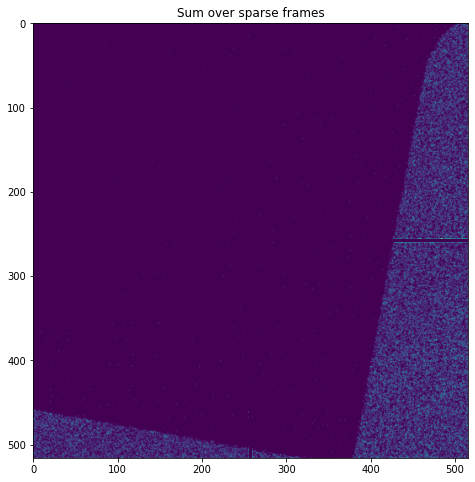

In [56]:
fig, ax = plt.subplots(figsize=(8, 8))
ax.set_title('Sum over sparse frames');
ax.imshow(sp_frames.sum(axis=0).todense());

Another feature this prototype is missing is accouting for rollover within a block of frames (and in the file as a whole). It should be feasible to add this into the existing functions, though.

#### Some additional function stubs

In [55]:
def symmetric_modulus(value, modulus):
    return np.abs(value - modulus) % modulus

def correct_epoch():
    ...


def average_hit_rate(timestamps: np.ndarray, offsets: np.ndarray) -> int:
    """
    Get number of hits per timestamp assuming all bytes are hits
    Timestamps are offset corrected
    
    could be made local in the file rather than unique whole-file
    
    returns a rate which is file bytes per 2**34 timestamp unit
    """
    _, rate = np.polynomial.polynomial.polyfit(timestamps, offsets, 1)
    return rate


ROLLOVER_TIME = 26.8435456

def full_timestamp(value_s: float) -> int:
    units_per_second = 640000000 # == 2**34 / ROLLOVER_TIME, 640 MHz ??
    return int(value * units_per_second)